# IMPORT DATA AND LIBS

In [1]:
import pandas as pd #pandas for calc
import matplotlib.pyplot as plt #matplotlib for plot
import re #regular expression
import spacy #spacy for lemmatization
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import joblib

# EDA

In [5]:
data = pd.read_csv('twitter_training.csv')

In [6]:
data_valid = pd.read_csv('twitter_validation.csv')

In [7]:
data.head()

2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...

In [8]:
data_valid.columns = ['ID', 'entity', 'sentiment', 'content']
data_valid.head(5)

ID     entity sentiment  \
0   352     Amazon   Neutral   
1  8312  Microsoft  Negative   
2  4371      CS-GO  Negative   
3  4433     Google   Neutral   
4  6273       FIFA  Negative   

                                             content  
0  BBC News - Amazon boss Jeff Bezos rejects clai...  
1  @Microsoft Why do I pay for WORD when it funct...  
2  CSGO matchmaking is so full of closet hacking,...  
3  Now the President is slapping Americans in the...  
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...

In [9]:
data.shape

(74681, 4)

In [10]:
data.columns = ['ID', 'entity', 'sentiment', 'content']

entity
TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)        

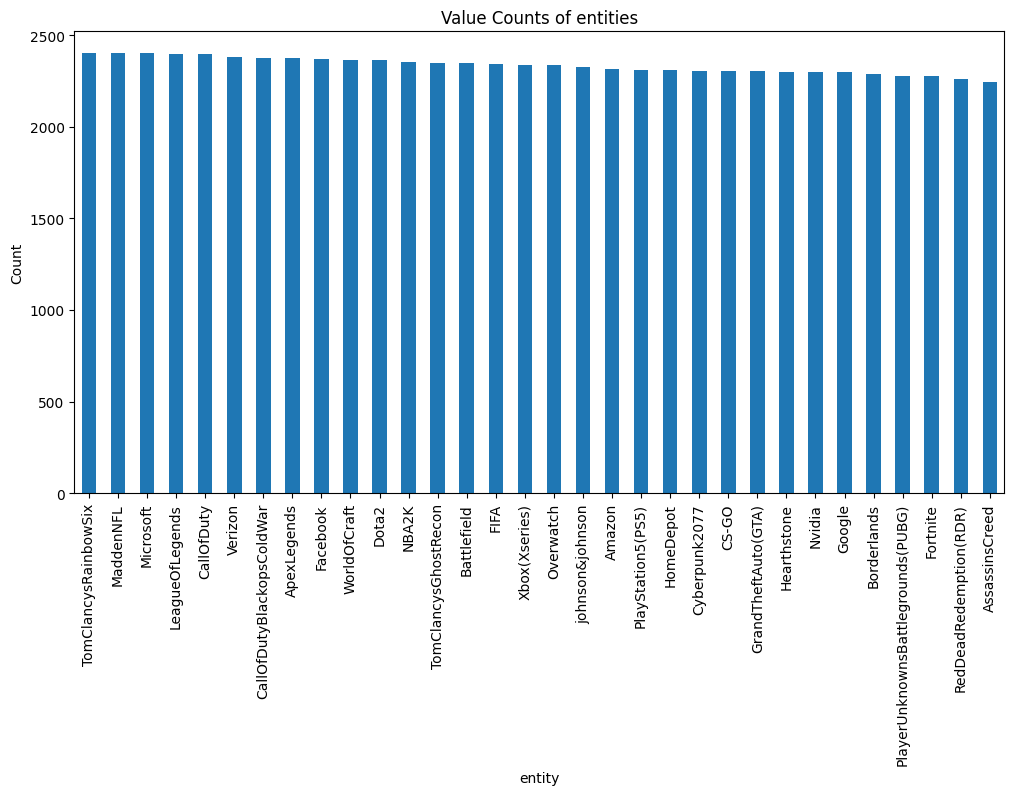

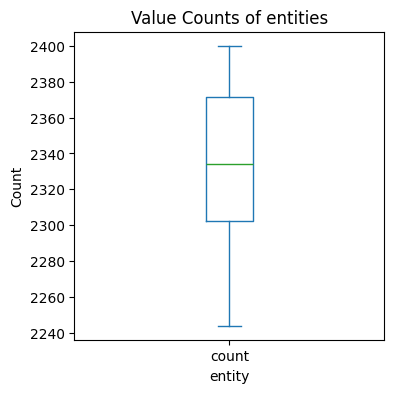

In [11]:
# Get the entity labels from the DataFrame
entity_labels = data['entity']

entity_labels = data["entity"].value_counts() #-> so we have 2161 disease in the dataset,
                                #some of them are with one mention only
                                #so they are not quite supported by data
                                #we should do augmentation (thanks to Artem for the idea)

print(entity_labels)

plt.figure(figsize=(12, 6))
entity_labels.plot(kind='bar')
plt.title('Value Counts of entities')
plt.xlabel('entity')
plt.ylabel('Count')
plt.xticks(fontsize=10) #decrease fontsize for readability - unfortunately, readablity is close to zero
plt.show()

plt.figure(figsize=(4, 4))
entity_labels.plot(kind='box')
plt.title('Value Counts of entities')
plt.xlabel('entity')
plt.ylabel('Count')
plt.xticks(fontsize=10)
plt.show()

In [12]:
data.head(10)

ID       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   
5  2402  Borderlands  Positive   
6  2402  Borderlands  Positive   
7  2402  Borderlands  Positive   
8  2402  Borderlands  Positive   
9  2402  Borderlands  Positive   

                                             content  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...  
5  So I spent a few hours making something for fu...  
6  So I spent a couple of hours doing something f...  
7  So I spent a few hours doing something for fun...  
8  So I spent a few hours making something for fu...  
9  2010 So I spent a few hours making something f...

# DATA PREPROCESSING

In [13]:
def clean_tweet(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
        text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\d+', '', text)  # Remove numbers
    else:
        text = ''  # Handle non-string inputs like float (NaN) by returning an empty string or handling as needed
    
    return text

In [14]:
# Apply the cleaning function to the 'content' column
data['clean_content'] = data['content'].apply(clean_tweet)

In [15]:
data_valid['clean_content'] = data_valid['content'].apply(clean_tweet)

In [16]:
data.head(5)

ID       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                             content  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

                                       clean_content  
0  i am coming to the borders and i will kill you...  
1  im getting on borderlands and i will kill you all  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands  and i will murder y...  
4  im getting into borderlands and i can murder y...

In [17]:
data_valid.head(5)

ID     entity sentiment  \
0   352     Amazon   Neutral   
1  8312  Microsoft  Negative   
2  4371      CS-GO  Negative   
3  4433     Google   Neutral   
4  6273       FIFA  Negative   

                                             content  \
0  BBC News - Amazon boss Jeff Bezos rejects clai...   
1  @Microsoft Why do I pay for WORD when it funct...   
2  CSGO matchmaking is so full of closet hacking,...   
3  Now the President is slapping Americans in the...   
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...   

                                       clean_content  
0  bbc news  amazon boss jeff bezos rejects claim...  
1   why do i pay for word when it functions so po...  
2  csgo matchmaking is so full of closet hacking ...  
3  now the president is slapping americans in the...  
4  hi  ive had madeleine mccann in my cellar for ...

# TOKENIZATION, LEMMATIZATION, VECTORIZING

## Scenario 1

In [18]:
nlp = spacy.load('en_core_web_sm')

In [19]:
type(nlp)

spacy.lang.en.English

In [20]:
def tokenize_and_lemmatize(text):
  """
  Tokenizes and lemmatizes the input text.

  Args:
      text: A string representing the input text.

  Returns:
      a list of lemmas
  """
  lemmas = []

  doc = nlp(text)

  for token in doc:
      if token.is_alpha and not token.is_stop:
          lemmas.append(token.lemma_)
    
  new_lemma_tokens = " ".join(lemmas) #Arsen was right -> I had indentation error

  return new_lemma_tokens

In [21]:
data['lemmas'] = data['clean_content'].apply(tokenize_and_lemmatize)

In [22]:
data.head(5)

ID       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                             content  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

                                       clean_content                    lemmas  
0  i am coming to the borders and i will kill you...          come border kill  
1  im getting on borderlands and i will kill you all     m get borderland kill  
2  im coming on borderlands and i will murder you...  m come borderland murder  
3  im getting on borderlands  and i will murder y...   m get borderland murder  
4  im getting into borderlands and i can murder y...   m get borderland murder

In [23]:
data_valid['lemmas'] = data_valid['clean_content'].apply(tokenize_and_lemmatize)

In [24]:
data_valid.head(5)

ID     entity sentiment  \
0   352     Amazon   Neutral   
1  8312  Microsoft  Negative   
2  4371      CS-GO  Negative   
3  4433     Google   Neutral   
4  6273       FIFA  Negative   

                                             content  \
0  BBC News - Amazon boss Jeff Bezos rejects clai...   
1  @Microsoft Why do I pay for WORD when it funct...   
2  CSGO matchmaking is so full of closet hacking,...   
3  Now the President is slapping Americans in the...   
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...   

                                       clean_content  \
0  bbc news  amazon boss jeff bezos rejects claim...   
1   why do i pay for word when it functions so po...   
2  csgo matchmaking is so full of closet hacking ...   
3  now the president is slapping americans in the...   
4  hi  ive had madeleine mccann in my cellar for ...   

                                              lemmas  
0  bbc news amazon boss jeff bezos rejects claim ...  
1                pay word function poorly chromebook  
2      csgo matchmaking closet hack truly awful game  
3  president slap americans face commit unlawful ...  
4  hi ve madeleine mccann cellar past year little...

SAVING STUFF

In [25]:
data.to_csv('data_lemmatized.csv')
data_valid.to_csv('data_valid_lemmatized.csv')

In [5]:
data = pd.read_csv('data_lemmatized.csv', index_col=0)
data_valid = pd.read_csv('data_valid_lemmatized.csv', index_col=0)

In [6]:
data.head(15)

ID       entity sentiment  \
0   2401  Borderlands  Positive   
1   2401  Borderlands  Positive   
2   2401  Borderlands  Positive   
3   2401  Borderlands  Positive   
4   2401  Borderlands  Positive   
5   2402  Borderlands  Positive   
6   2402  Borderlands  Positive   
7   2402  Borderlands  Positive   
8   2402  Borderlands  Positive   
9   2402  Borderlands  Positive   
10  2402  Borderlands  Positive   
11  2403  Borderlands   Neutral   
12  2403  Borderlands   Neutral   
13  2403  Borderlands   Neutral   
14  2403  Borderlands   Neutral   

                                              content  \
0   I am coming to the borders and I will kill you...   
1   im getting on borderlands and i will kill you ...   
2   im coming on borderlands and i will murder you...   
3   im getting on borderlands 2 and i will murder ...   
4   im getting into borderlands and i can murder y...   
5   So I spent a few hours making something for fu...   
6   So I spent a couple of hours doing something f...   
7   So I spent a few hours doing something for fun...   
8   So I spent a few hours making something for fu...   
9   2010 So I spent a few hours making something f...   
10                                                was   
11  Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...   
12  Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...   
13  Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...   
14  Rock-Hard La Vita, RARE BUT POWERFUL, HANDSOME...   

                                        clean_content  \
0   i am coming to the borders and i will kill you...   
1   im getting on borderlands and i will kill you all   
2   im coming on borderlands and i will murder you...   
3   im getting on borderlands  and i will murder y...   
4   im getting into borderlands and i can murder y...   
5   so i spent a few hours making something for fu...   
6   so i spent a couple of hours doing something f...   
7   so i spent a few hours doing something for fun...   
8   so i spent a few hours making something for fu...   
9    so i spent a few hours making something for f...   
10                                                was   
11  rockhard la varlope rare  powerful handsome ja...   
12  rockhard la varlope rare  powerful handsome ja...   
13  rockhard la varlope rare  powerful handsome ja...   
14  rockhard la vita rare but powerful handsome ja...   

                                               lemmas  
0                                    come border kill  
1                               m get borderland kill  
2                            m come borderland murder  
3                             m get borderland murder  
4                             m get borderland murder  
5   spend hour make fun not know huge fan maya fav...  
6   spend couple hour fun not know m huge borderla...  
7   spend hour fun not know m huge borderland fan ...  
8   spend hour make fun not know huge rhandlerr fa...  
9   spend hour make fun not know huge rhandlerr fa...  
10                                                NaN  
11  rockhard la varlope rare powerful handsome jac...  
12  rockhard la varlope rare powerful handsome jac...  
13  rockhard la varlope rare powerful handsome jac...  
14  rockhard la vita rare powerful handsome jackpo...

Vectorization using TF IDF

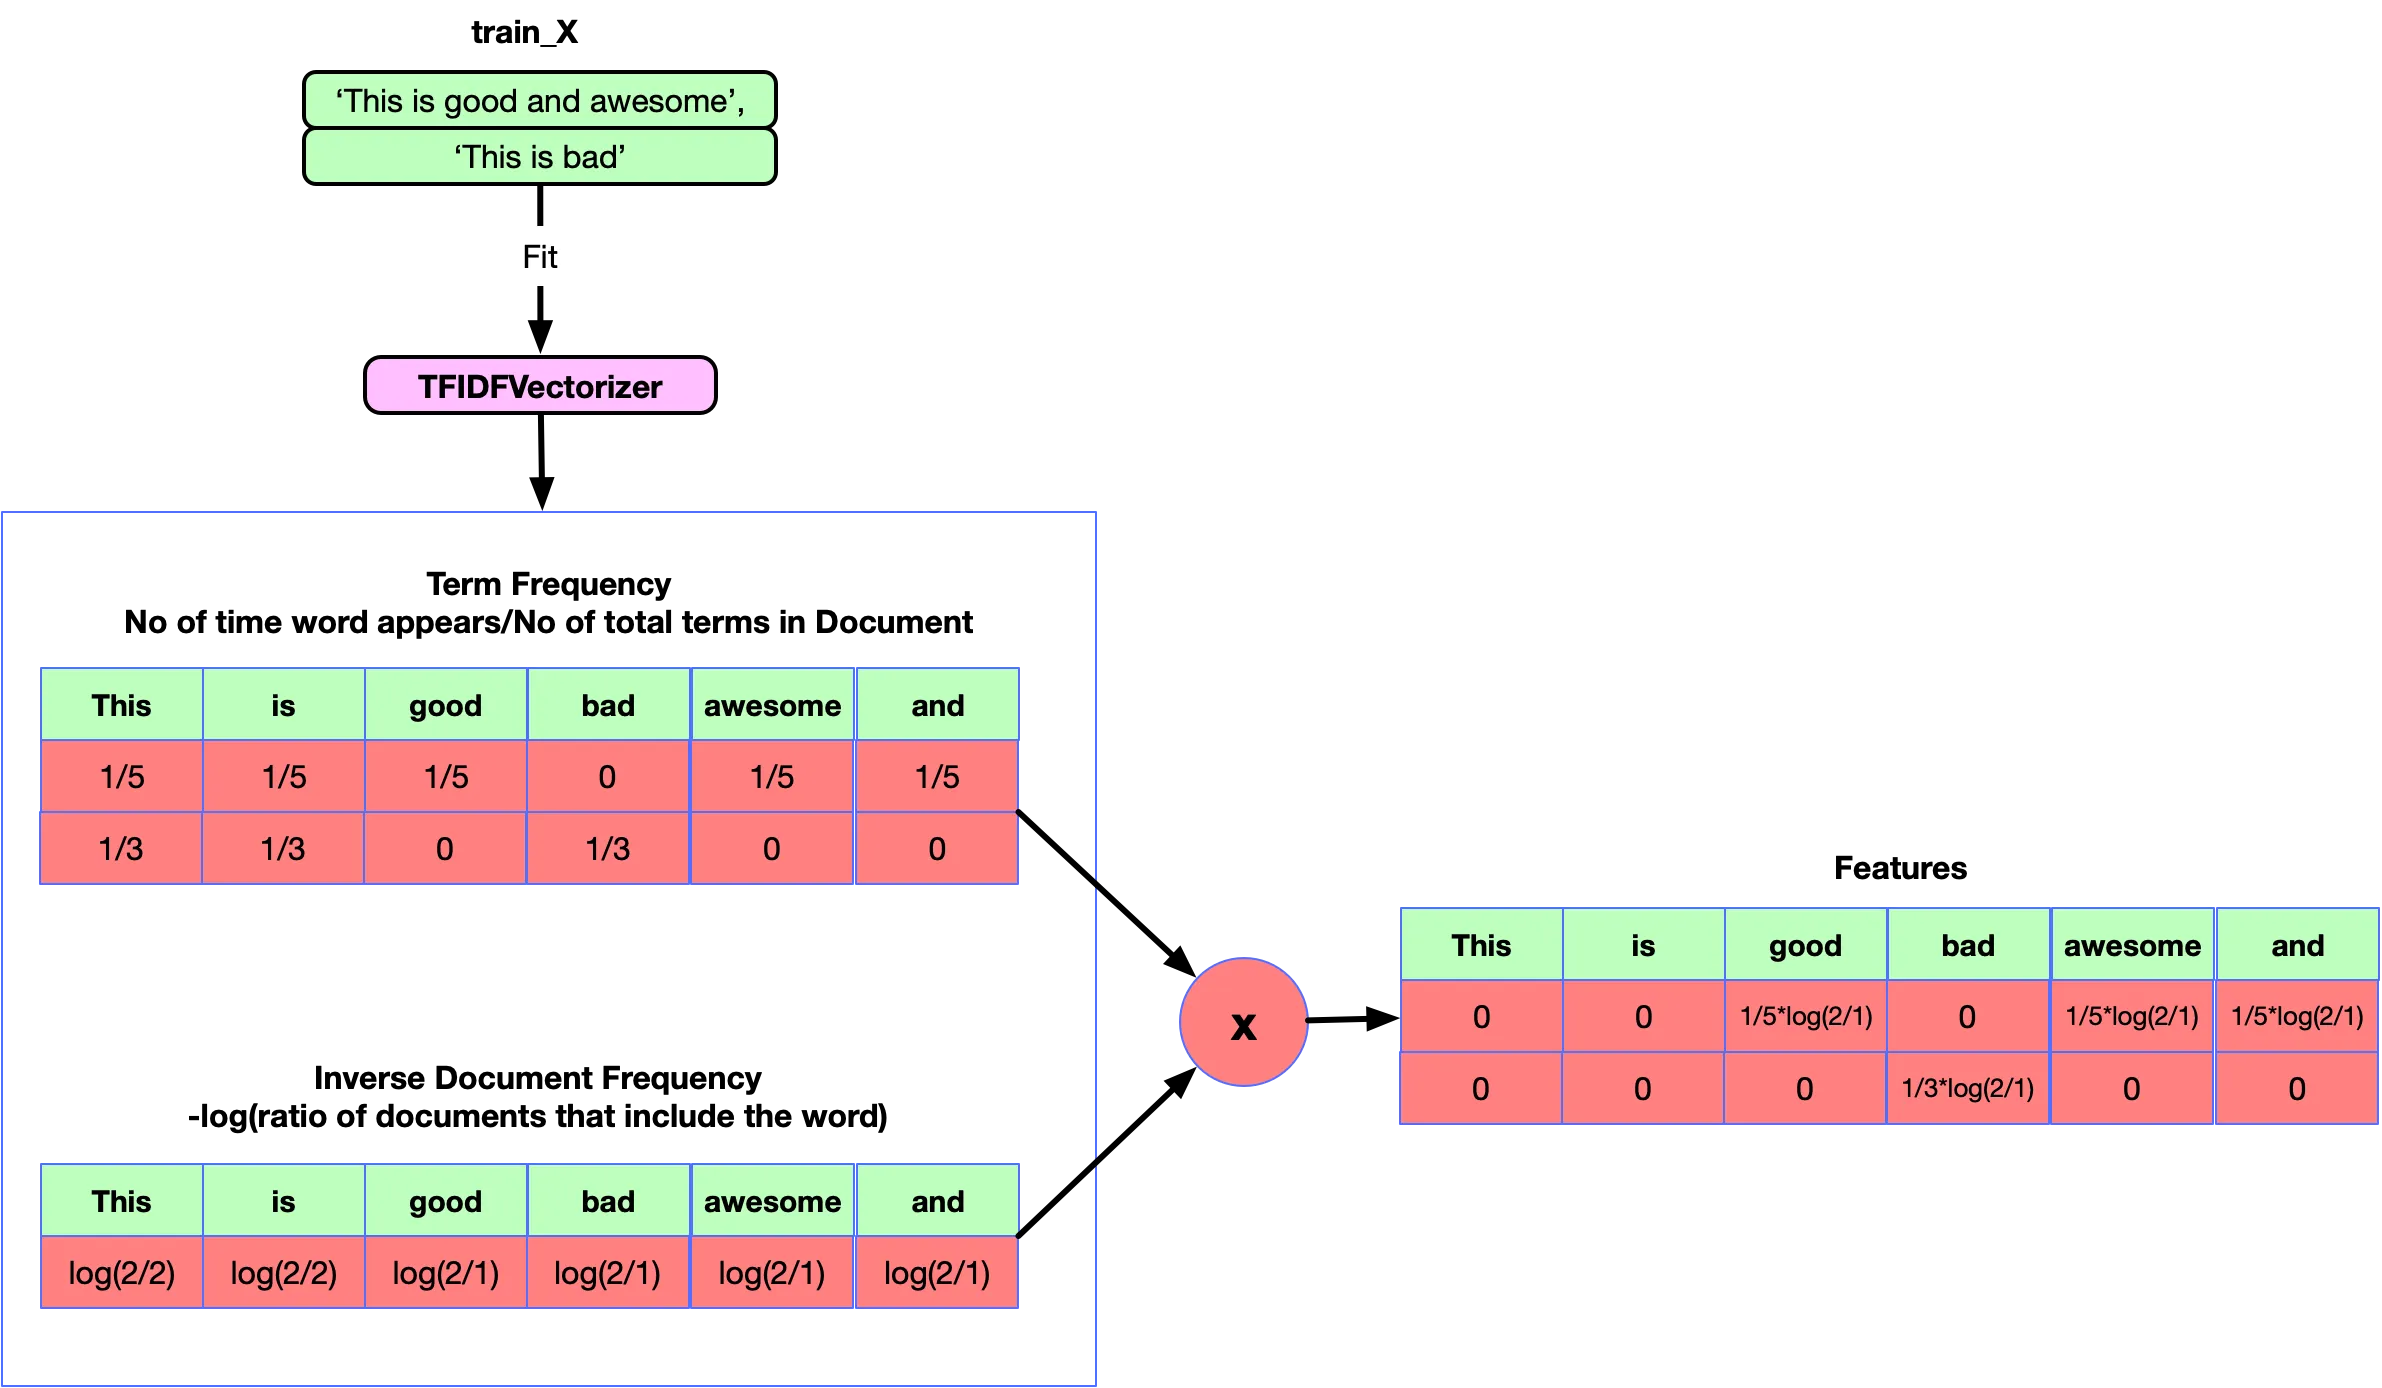

In [26]:
#vectorizing the lemmatized text
vectorizer = TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2), stop_words='english', norm='l2')
vectorized_data = vectorizer.fit_transform(data['lemmas'])
vectorized_data = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())
print(vectorized_data.shape)

(74681, 10000)


In [27]:
vectorized_data.head(10)

aa  aa aa  aaa  aaron   ab  abandon  abandon sanction  abc  abella  \
0  0.0    0.0  0.0    0.0  0.0      0.0               0.0  0.0     0.0   
1  0.0    0.0  0.0    0.0  0.0      0.0               0.0  0.0     0.0   
2  0.0    0.0  0.0    0.0  0.0      0.0               0.0  0.0     0.0   
3  0.0    0.0  0.0    0.0  0.0      0.0               0.0  0.0     0.0   
4  0.0    0.0  0.0    0.0  0.0      0.0               0.0  0.0     0.0   
5  0.0    0.0  0.0    0.0  0.0      0.0               0.0  0.0     0.0   
6  0.0    0.0  0.0    0.0  0.0      0.0               0.0  0.0     0.0   
7  0.0    0.0  0.0    0.0  0.0      0.0               0.0  0.0     0.0   
8  0.0    0.0  0.0    0.0  0.0      0.0               0.0  0.0     0.0   
9  0.0    0.0  0.0    0.0  0.0      0.0               0.0  0.0     0.0   

   abella danger  ...  zion  zip  zoe  zombie  zombie fucking  zone  \
0            0.0  ...   0.0  0.0  0.0     0.0             0.0   0.0   
1            0.0  ...   0.0  0.0  0.0     0.0             0.0   0.0   
2            0.0  ...   0.0  0.0  0.0     0.0             0.0   0.0   
3            0.0  ...   0.0  0.0  0.0     0.0             0.0   0.0   
4            0.0  ...   0.0  0.0  0.0     0.0             0.0   0.0   
5            0.0  ...   0.0  0.0  0.0     0.0             0.0   0.0   
6            0.0  ...   0.0  0.0  0.0     0.0             0.0   0.0   
7            0.0  ...   0.0  0.0  0.0     0.0             0.0   0.0   
8            0.0  ...   0.0  0.0  0.0     0.0             0.0   0.0   
9            0.0  ...   0.0  0.0  0.0     0.0             0.0   0.0   

   zonestreamcx  zoom  zsmitty  zuckerberg  
0           0.0   0.0      0.0         0.0  
1           0.0   0.0      0.0         0.0  
2           0.0   0.0      0.0         0.0  
3           0.0   0.0      0.0         0.0  
4           0.0   0.0      0.0         0.0  
5           0.0   0.0      0.0         0.0  
6           0.0   0.0      0.0         0.0  
7           0.0   0.0      0.0         0.0  
8           0.0   0.0      0.0         0.0  
9           0.0   0.0      0.0         0.0  

[10 rows x 10000 columns]

In [28]:
val_vectorized_data = vectorizer.fit_transform(data_valid['lemmas'])
val_vectorized_data = pd.DataFrame(val_vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())
print(val_vectorized_data.shape)

(999, 10000)


In [29]:
vectorized_data.to_csv("vectorized_data.csv")

In [30]:
val_vectorized_data.to_csv("val_vectorized_data.csv")

## Scenario 2

# FEATURE ENGINEERING

# MODELS CHOICE + TRAINING

In [33]:
data = pd.read_csv('data_lemmatized.csv', index_col=0)
data_valid = pd.read_csv('data_valid_lemmatized.csv', index_col=0)

In [34]:
data.head(5)

ID       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                             content  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

                                       clean_content                    lemmas  
0  i am coming to the borders and i will kill you...          come border kill  
1  im getting on borderlands and i will kill you all     m get borderland kill  
2  im coming on borderlands and i will murder you...  m come borderland murder  
3  im getting on borderlands  and i will murder y...   m get borderland murder  
4  im getting into borderlands and i can murder y...   m get borderland murder

In [35]:
data_valid.head(5)

ID     entity sentiment  \
0   352     Amazon   Neutral   
1  8312  Microsoft  Negative   
2  4371      CS-GO  Negative   
3  4433     Google   Neutral   
4  6273       FIFA  Negative   

                                             content  \
0  BBC News - Amazon boss Jeff Bezos rejects clai...   
1  @Microsoft Why do I pay for WORD when it funct...   
2  CSGO matchmaking is so full of closet hacking,...   
3  Now the President is slapping Americans in the...   
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...   

                                       clean_content  \
0  bbc news  amazon boss jeff bezos rejects claim...   
1   why do i pay for word when it functions so po...   
2  csgo matchmaking is so full of closet hacking ...   
3  now the president is slapping americans in the...   
4  hi  ive had madeleine mccann in my cellar for ...   

                                              lemmas  
0  bbc news amazon boss jeff bezos rejects claim ...  
1                pay word function poorly chromebook  
2      csgo matchmaking closet hack truly awful game  
3  president slap americans face commit unlawful ...  
4  hi ve madeleine mccann cellar past year little...

In [36]:
#X_train = data['lemmas']
#y_train = data['sentiment']

X_val = data_valid['lemmas']
y_val = data_valid['sentiment']

In [37]:
X_val.head(10)
y_val.head(5)

0     Neutral
1    Negative
2    Negative
3     Neutral
4    Negative
Name: sentiment, dtype: object

In [ ]:
# data["lemmas"], data["sentiment"]
# X_i               y_i

In [39]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_data, data['sentiment'], test_size=0.2, random_state=42)

In [43]:
X_train.to_csv("X_train.csv")

In [9]:
X_train = pd.read_csv("X_train.csv", index_col=0)

In [8]:
X_train.head()
#y_test.head()

NameError: name 'X_train' is not defined

In [48]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [49]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("F1 score:", f1)

Accuracy: 0.8615518511079869
F1 score: 0.8585531990495172


In [51]:
joblib.dump(rf, 'rf_model.joblib')

['rf_model.joblib']

# MODEL VALIDATION

### do not forget to save the model

# MOVING TO STREAMLIT APP

# Testing hypothetical input
for streamlit side

In [42]:
def tokenize_and_lemmatize(text):
  """
  Tokenizes and lemmatizes the input text.

  Args:
      text: A string representing the input text.

  Returns:
      a list of lemmas
  """
  lemmas = []

  doc = nlp(text)

  for token in doc:
      if token.is_alpha and not token.is_stop:
          lemmas.append(token.lemma_)
          new_lemma_tokens = " ".join(lemmas)

  return new_lemma_tokens

nlp = spacy.load('en_core_web_sm')

rf_model = joblib.load('rf_model.joblib')

user_input = "I didn't want to hurt you, I just got lucky" 
user_input = user_input.lower()

#vectorizing the lemmatized text
user_input = tokenize_and_lemmatize(user_input)
print(user_input)

vectorizer = TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1, 2))
vectorized_input = vectorizer.fit_transform([user_input])
vectorized_input = pd.DataFrame(vectorized_input.toarray(), columns=vectorizer.get_feature_names_out())

print(vectorized_input.head(1))

#finding the missing columns in the test dataframe
#filling missing columns with zeros -> they don't exist in the train dataframe
missing_columns = set(X_train.columns) - set(vectorized_input.columns)
for col in missing_columns:
    vectorized_input[col] = 0

vectorized_input = vectorized_input[X_train.columns]
print(vectorized_input.head(1))

#predicting
y_pred_input = rf_model.predict(vectorized_input)
print(f"Prediction for the user input is {y_pred_input}")

new work new opportinutie
        new  new opportinutie  new work  opportinutie      work  work new
0  0.666667          0.333333  0.333333      0.333333  0.333333  0.333333


C:\Users\User3\AppData\Local\Temp\ipykernel_17704\3697824504.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vectorized_input[col] = 0
C:\Users\User3\AppData\Local\Temp\ipykernel_17704\3697824504.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vectorized_input[col] = 0
C:\Users\User3\AppData\Local\Temp\ipykernel_17704\3697824504.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

   aa  aa aa  aaa  aaron  ab  abandon  abandon sanction  abc  abella  \
0   0      0    0      0   0        0                 0    0       0   

   abella danger  ...  zion  zip  zoe  zombie  zombie fucking  zone  \
0              0  ...     0    0    0       0               0     0   

   zonestreamcx  zoom  zsmitty  zuckerberg  
0             0     0        0           0  

[1 rows x 10000 columns]
Prediction for the user input is ['Positive']
